In [1]:
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams["figure.facecolor"] = "green"

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж репетитора
              [500, 700, 750, 600, 1450,        # средняя стоимость занятия
               800, 1500, 2000, 450, 1000],
              [21, 25, 27, 20, 25, 18, 35, 60, 20, 30]],  # возраст репетитора
              dtype = np.float64).T 

y = np.array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0]) # подходит или нет репетитор

X

array([[1.00e+00, 1.00e+00, 5.00e+02, 2.10e+01],
       [1.00e+00, 1.00e+00, 7.00e+02, 2.50e+01],
       [1.00e+00, 2.00e+00, 7.50e+02, 2.70e+01],
       [1.00e+00, 1.00e+00, 6.00e+02, 2.00e+01],
       [1.00e+00, 3.00e+00, 1.45e+03, 2.50e+01],
       [1.00e+00, 0.00e+00, 8.00e+02, 1.80e+01],
       [1.00e+00, 5.00e+00, 1.50e+03, 3.50e+01],
       [1.00e+00, 1.00e+01, 2.00e+03, 6.00e+01],
       [1.00e+00, 1.00e+00, 4.50e+02, 2.00e+01],
       [1.00e+00, 2.00e+00, 1.00e+03, 3.00e+01]])

In [3]:
def calc_logloss(y, p):
    err = np.mean(- y * np.log(p) - (1.0 - y) * np.log(1.0 - p))
    return err

### Домашние задания

1. Измените функцию `calc_logloss` так, чтобы нули по возможности не попадали в `np.log` (как вариант - использовать `np.clip` или `np.where`).  

Очень интересная задача.

использование функции numpy.clip непосрественно не решает проблемы: "обрезка" идет по границам интервала включительно, т.е. 0 и 1 попадают в функцию логарифма.

Можно попытаться схитрить. Минимальное положительное число которое python не считает нулем (я нашел методом проб) - 10e-323; Тогда выходом может быть задать интервал $[10^{-323}, 1- 10^{-323}]$; Здесь неожиданно проблема в том что $1 - (1 - 10^{-323}) = 0 \neq 10^{-323}$. Это раз.

Во-вторых, `numpy.log(1e-323)` это не какая-то заоблачная цифра чуть большая чем $-\infty$, это просто `-743.7469`   )))

Поэтому в качестве такого зазора придется использовать число порядка $10^{-16}$;

In [4]:
def logloss_modif(y, p):
    
    p = np.clip(p, 1e-16, (1-1e-16))
    err = np.mean(- y * np.log(p) - (1.0 - y) * np.log(1.0 - p))
    return err

2. На данных из урока изучите влияние гиперпараметров на ошибку алгоритма. 

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
    
def stand_scaler(arr):
    return (arr - arr.mean(axis=0)) / arr.std(axis=0)

In [6]:
def logreg_classifier(X, y, iter_=1e3, eta=1e-2):
    
    np.random.seed(42)
    # предполагаем что признаки в столбцах
    n = len(X)
    m = len(X[0])
    w = np.random.randn(m)
    i = 0
    
    X[:,1:] = stand_scaler(X[:,1:])
    
    while i < iter_:
        pred = X @ w
        prob = sigmoid(pred)
        err = logloss_modif(y, prob)
        w -= 1/n * eta * ((prob - y) @ X)
        i += 1
    
    return w, err

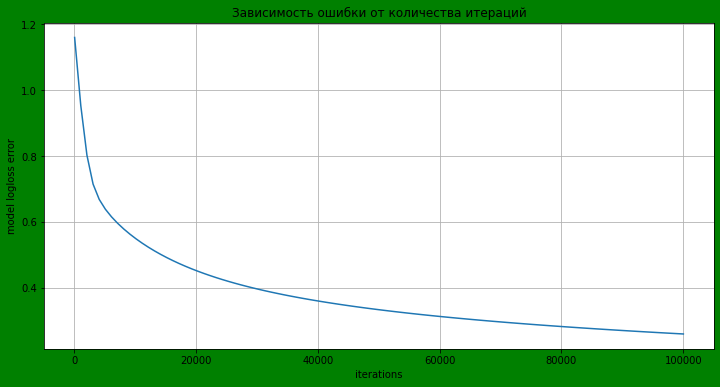

In [7]:
iterations = np.linspace(1e2, 1e5, 100)
err_arr = []

for i in iterations:
    err_arr.append(logreg_classifier(X, y, iter_=i, eta=1e-3)[1])
    
plt.figure(figsize=(12,6))
plt.title("Зависимость ошибки от количества итераций")
plt.xlabel("iterations")
plt.ylabel("model logloss error")
plt.plot(iterations, err_arr)
plt.grid()
plt.show()

##### Вывод: с ростом итераций дисперсия (вариативность) ошибки заметно снижается и стабилизируется после 20000 итераций.

In [11]:
def accu_metric(y, w, eta=1e-3, threshold=.5):
#     cls_pred = np.where(sigmoid(X @ logreg_classifier(X, y, eta=eta)[0]) < .5, 0, 1)
    cls_pred = np.where(sigmoid(X @ w) < threshold, 0, 1)
    accu = sum([1 if cls_pred[i] == y[i] else 0 for i in range(len(y))]) / len(y)
    return accu

In [12]:
w2 = logreg_classifier(X, y, iter_=2e4, eta=1e-2)[0]
accu_metric(y, w2)

0.9

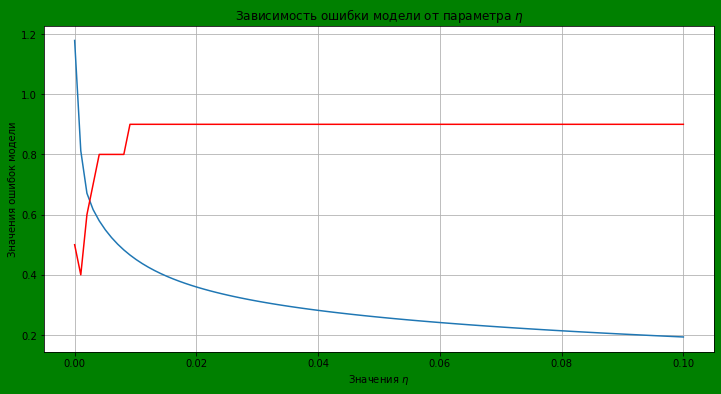

In [13]:
eta_s = np.linspace(1e-1, 1e-5, 100)
res_err = []
res_acc = []

for eta in eta_s:
    w, err = logreg_classifier(X, y, iter_=2000, eta=eta)
    res_err.append(err)
    res_acc.append(accu_metric(y, w))
    
plt.figure(figsize=(12,6))
plt.plot(eta_s, res_err)
plt.plot(eta_s, res_acc, c="r")
plt.xlabel("Значения $\eta$")
plt.ylabel("Значения ошибок модели")
plt.title("Зависимость ошибки модели от параметра $\eta$")
plt.grid()
plt.show()

##### Вывод: чем больше значение $\eta$ тем меньше значение функции потерь.

немного неожиданно...

А что если посмотреть как влияет этот параметр на метрики (например на accuracy) - растет чем больше шаг.

3. Создайте функцию `calc_pred_proba`, возвращающую предсказанную вероятность класса "1". На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией `eval_LR_model`.

ну собственно почти такая функция готова выше))

In [14]:
def calc_pred_proba(X, w):
    proba = sigmoid(X @ w)
    return proba

4. Создайте функцию `calc_pred`, возвращающую предсказанные классы (0 или 1). На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией `eval_LR_model`, а также порог вероятности.

In [15]:
def calc_pred(X, w, threshold=.5):
    cls_pred = np.where(sigmoid(X @ w) < threshold, 0, 1)
#     accu = sum([1 if cls_pred[i] == y[i] else 0 for i in range(len(y))]) / len(y)
    return cls_pred

In [16]:
w1 = logreg_classifier(X, y)[0]
print(f"вероятности принадлежности классу: {calc_pred_proba(X, w1).round(2)}\n"
      f"предсказание класса: {calc_pred(X, w1, threshold=.6)}\n"
      f"метрика accuracy: {accu_metric(y, w1, threshold=1):.2f}\n")

вероятности принадлежности классу: [0.34 0.43 0.36 0.39 0.62 0.58 0.46 0.26 0.32 0.48]
предсказание класса: [0 0 0 0 1 0 0 0 0 0]
метрика accuracy: 0.60



5. (\*) Напишите функции для расчета accuracy, матрицы ошибок, precision и recall, а также F1-score.

In [17]:
def metrics(X, y, threshold=.5):
    w = logreg_classifier(X, y, iter_=2e4)[0]
    cls_pred = np.where(sigmoid(X @ w) < threshold, 0, 1)
    
    TP, FP, FN, TN = 0, 0, 0, 0
    
    for cnt, val in enumerate(y):
        if val == 0:
            if cls_pred[cnt] == 0:
                TN += 1
            else:
                FP += 1
        else:
            if cls_pred[cnt] == 1:
                TP += 1
            else:
                FN += 1
    
    confusion_matrix = [[TP, FP], [FN, TN]]
    accuracy = (TP + TN) / len(y)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * precision * recall / (precision + recall)
    
    print(f"accuracy:={accuracy:.2f}\n"
          f"precision:={precision:.2f}\n"
          f"recall:={recall:.2f}\n"
          f"F1-score:={F1_score:.2f}\n"
          f"confusion matrix: {confusion_matrix}")
    return accuracy, precision, recall, round(F1_score, 2), confusion_matrix

In [18]:
metrics(X, y)

accuracy:=0.90
precision:=1.00
recall:=0.75
F1-score:=0.86
confusion matrix: [[3, 0], [1, 6]]


(0.9, 1.0, 0.75, 0.86, [[3, 0], [1, 6]])